# Jupyter Notebook 1: Text Classifiction 
### Based on Tensorflow Documentation

## The Data and Software

* Let's start by making a very simple neural network, fit it on some data and asses its performance using what we learned. 

* This lecture is based on the tutorials provided on the Tensorflow website. Tensorflow provides a series of example datasets that you can download and play around with. We will play with two today, the Higgs dataset (sims) and the IMDB dataset. Both of these are large enough datasets (50,000 movie reviews and 500,000 events). I recommend playing with both.

* We'll skip over regression, as text classification will only require one more conceptual jump. 



## The goal
* We are going to try and predict whether a movie review is positive or negative just by reading it. This is a binary classification problem (although it could be easily adapted to a regression problem). We have a prelabelled dataset which we will download. How would you do this if you didn't know machine learning existed?

## Packages
* We will import the basic os integration, and numpy. 
* We also need tensorflow (the central package) and keras which is neural network utilities. Keras can be used on its own but it is most common to use it in the tensorflow framework

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

## Download the IMDB dataset and Organize

* This next block downloads all the data. Normally you will be using your own data but tensorflow is particular on the organization of data. Watch out for database objects in the beginner tutorials. Getting data out of these objects is unintuitive. 

* The data will already be organized into a training set and a test set so let’s look at this along with the structure of the text files.

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')

## Data Structure

* This data is already sorted into a logical hierarchy split into an equal sized training and testing data set. This is a process you would need to do yourself. You can see that the labels come from the folder. They are sorted into positive and negative reviews.
* Each of the actual data files is a test file with a positive or negative review. We can import these simply as strings. The data itself contains punctuation and html keys so how do we handle this?
* The tensor flow hierarchy of files is:
 ```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

* The data downloaded also has an 'unsup' folder which we will remove.

In [3]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

samps= ['pos/11877_10.txt', 'pos/11824_10.txt', 'neg/8058_1.txt', 'neg/8047_2.txt']
for fil in samps:
    sample_file = os.path.join(train_dir,fil)
    with open(sample_file) as f:
        print(f.read())
        print('\n------------------------------------\n')

Directed by Brian De Palma and written by Oliver Stone, "Scarface" is a movie that will not be forgotten. A Cuban refugee named Tony Montana (Pacino) comes to America for the American Dream. Montana then becomes the "king" in the drug world as he ruthlessly runs his empire of crime in Miami, Florida. This gangster movie is very violent, and some scenes are unpleasant to watch. This movie has around 180+ F-words and is almost three hours long. This movie is entertaining and you will never get bored. You cheer for the Drug-lord, and in some scenes you find out that Montana isn't as evil as some other Crime Lords. This is a masterpiece and i recommend that you see this. You will not be disappointed. 9/10

------------------------------------

Dick Tracy is easily the best comic book based movie made to date. The movie has the same feel as the comic book, staying true to the color scheme. The Batman series has climbed, fallen, climbed and fallen again. Dick Tracy has true staying power as 

## Dataset Object
* We want to create a training dataset object and to do this we will use the Kera preprocessing utility. If you can ever get your data into a format where these utilities work, it will make your life a lot easier. 
* In this step we will also split our training data into a training and validation data set (80-20 split).
* You can call keras once or twice, but if you call it twice then you need the seed to be defined or you will shuffle twice. 



In [4]:
batch_size = 32 #Size of the batches
seed = 42 # To make sure we get the same answer because we shuffle the input

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)
raw_train_ds

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2021-11-22 19:30:18.692924: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/matthew/CLUMPY/lib:/home/matthew/GreAT-master//lib:/home/matthew/rootinstall/lib::/usr/local/veritas/lib:/home/matthew/vegas-install/vegas-v2-05-07/lib:/home/matthew/local/lib:/home/matthew/local/include
2021-11-22 19:30:18.692982: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-22 19:30:18.693027: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2021-11-22 19:30:18.693338: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical op

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int32)>

## Labels
* The Keras tool will automatically get the name of the classes from the folder names. To check which is which we can just select the appropriate "class_names" from the dataset object. 


In [5]:
print(raw_train_ds.class_names[0])
print(raw_train_ds.class_names[1])

neg
pos


## Standardize Tokenize and Vectorize

* This is the stage where we clean the data and convert non-numerical data into numerical data

* Standardization is a process by which we simplify the data by removing anything that may cause us problems. This is things like html codes. 

* Tokenization is splitting large data into tokens. In this case splitting strings into words. This is normally done with whitespace. 

* Vectorization converts these tokens into numerical values. We will use a `TextVectorization` layer that adapts our mapping. Vectorization and tokenizing are both handled by the same layer. You can substitute this layer with previous vectorization networks for an improved result (transfer learning). 


In [6]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

2021-11-22 19:30:20.214265: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [7]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label


text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[1], label_batch[1]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"This Italian film from the '70's is NOT even in the class with Dog Soldiers, The Howling, or even that awful American Werewolf in Paris, BUT...it is fun to watch. I'm talking about watching the lead actress, a stunning blonde, run amok in her birthday suit. We're talking about graphic, complete nudity...it's obvious that she is a real blonde...humma humma humma!! The story is a hoot, the SFX are childish, and the acting (for the most part) stinks. The only redeeming value of this movie is all (and there is a LOT) the nudity & sex scenes. Tame by HBO standards, but still fun to see when you find yourself without a date on Saturday night. OK...HERE'S THE SPOILER...There is NO werewolf (except in the opening scene of the heroine(??)'s ancestor. The girl just imagines that she's a werewolf...in other words, a clinical Lycanthrope.", shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  11, 1175,   19,   35,    2,  

## Applying Map
* Great now we can map all of our data to integers in a commonly shaped tensor
* We will no apply this map
* This isn't the last step, all we've done is an initial vectorization. None of the words carry with them connections about the other words. This step is called embedding and we will build it into our network 

In [8]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## Improving Training Speed

* Neural networks are pretty slow and so anything you can do to remove bottlenecks is pretty important. 

* If you have a GPU, use it! 

* Defining a `.cache()` and a `.prefetch()` will help mitigate I/O issues. The `AUTOTUNE` option will try and calculate this for you manually but for more advanced applications you will have to tweak this yourself. 



In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


### The Network Structure
* We now want to define the layers of our network. The first layer will be an embeding layer. This takes up our vector and looks up the embedding which encodes the connections between words. This will train as our model trains. 

* The next layer is just a pooling layer. Since our input is of variable length this is necessary. This would not be required if all reviews were the same length.

* Now the actual neural network (the so called `Dense` layer). This is just 16 connections linking everything from the pooling network.


In [10]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  #layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  #layers.Dropout(0.2),
  #layers.Dense(16,kernel_regularizer=regularizers.l2(0.001)),
  #layers.Dropout(0.2),

# layers.Dense(1,kernel_regularizer=regularizers.l2(0.001))])
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


### Visualization of the Embedding layers
* Let's visualize what's happening with a rough PCA (principal component analysis):https://projector.tensorflow.org/
* The next box will just save our embedding layers so we can read them into the projector. 
* The projector will select new combinations of coordinates based on the vectors we send in and should give us a rough sense of what's going on by eliminating some of the less important dimensions. 

In [11]:
import io
weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')
for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()


### Loss function and optimizer
* Now we need to define our loss funciton and the optimizer. 
* We will use modified gradient descent ('adam') although other options are available ('SGD') 
* Our loss function will be the binary cross entropy defined as
BinaryCrossEntropy= $-(y\log(p)+(1-y)\log(1-p))$
* The metric is how we evaluate the accuracy of our model. In this case it will take the most likely review and check it against the real review. The metric can be different from the crossentropy and does not affect the model at all.



In [12]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

## Training

* Now all you need to do is run through a couple gradient descents. 
* The epoch is just how many times you've run through the training set.
* This is a fairly simple network and so each epoch ~2 s. 
* This is normally the longest step computationally. 

In [13]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
     )

Epoch 1/10
625/625 [==============================] - 4s 5ms/step - loss: 0.6573 - binary_accuracy: 0.7006 - val_loss: 0.5990 - val_binary_accuracy: 0.7788
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.5265 - binary_accuracy: 0.8121 - val_loss: 0.4755 - val_binary_accuracy: 0.8294
Epoch 3/10
625/625 [==============================] - 2s 4ms/step - loss: 0.4192 - binary_accuracy: 0.8532 - val_loss: 0.3999 - val_binary_accuracy: 0.8546
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3547 - binary_accuracy: 0.8735 - val_loss: 0.3575 - val_binary_accuracy: 0.8644
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3136 - binary_accuracy: 0.8853 - val_loss: 0.3318 - val_binary_accuracy: 0.8718
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2841 - binary_accuracy: 0.8953 - val_loss: 0.3151 - val_binary_accuracy: 0.8736
Epoch 7/10
625/625 [==============================] - 2s 4ms/ste

In [14]:
import io
weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

out_v = io.open('vectors2.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata2.tsv', 'w', encoding='utf-8')
for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()


## True accuracy 
* Now we can use our testing data set. We will asses the loss and accuracy of the model, this should be worse than our loss and binary accuracy in the fitting. 
* The larger this difference the larger our overfitting. 
* Recall loss is like Chi-Sq

In [15]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 2ms/step - loss: 0.3076 - binary_accuracy: 0.8743
Loss:  0.30755317211151123
Accuracy:  0.8743199706077576


## Diagnostics

* The history object is basically the chains we stored in class. We can use it to plot accuracy or loss over time. 
* val_ denotes the validation dataset. 

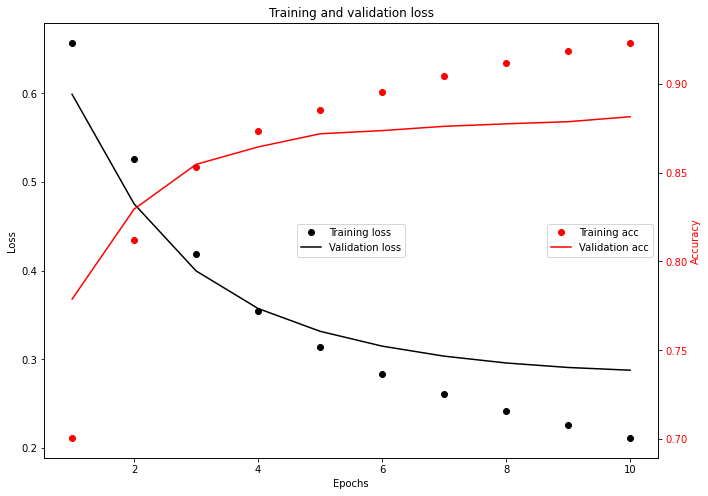

In [16]:
history_dict = history.history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig,axs=plt.subplots()
fig.set_size_inches(11,8)
axs.plot(epochs, loss, 'ko', label='Training loss')
axs.plot(epochs, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
plt.legend(loc='center')


axs1 = axs.twinx()

axs1.plot(epochs, acc, 'ro', label='Training acc')
axs1.plot(epochs, val_acc, 'r', label='Validation acc')

axs1.set_ylabel('Accuracy',color='r')
axs1.tick_params(axis='y', labelcolor='r')
plt.legend(loc='center right')

plt.show()

## Export the model

* The final step is to add the vecotrization layer to the model and also add a sigmoid at the end to translate the ouput into a probability. This is done using the Sequential command. We can test this now on the raw strings we extracted earlier. The accuracy should be the same. We can also test it on user input. 

In [17]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 3s 3ms/step - loss: 0.3076 - accuracy: 0.8743
0.8743199706077576


## Using the model

Now the model can be used as a function where any string can be added and the classifier should be able to tell you if the movie was good or not. 

In [18]:
examples=[str(input())]
export_model.predict(examples)

KeyboardInterrupt: Interrupted by user

In [ ]:
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.
